# Fast Fourier Transform Demo

This is an interactive demo for Fast Fourier transforms that is meant to serve as some hands-on experience with the discrete fourier transform.

First, we load an audio file:

In [1]:
import scipy
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
sample_rate, samples = scipy.io.wavfile.read("MEDIA2.wav")
print(sample_rate)
Audio(samples, rate=sample_rate)

44100


You've heard this one before, it's the example of the lecture. Despite what the gizmo above might say, it's a 4 second clip and it's being sampled at 44.1KHz, [a very common samplling frequency](https://en.wikipedia.org/wiki/44,100_Hz).

Because the audio comes in a WAV file, the samples are 16 bit signed integers, but we prefer to work with floats, so we convert and normalize the samples:

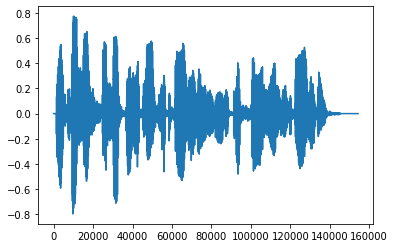

In [2]:
samples = samples.astype(np.double) / 32767
plt.plot(samples)

Note that the y-scale of the waveform is arbitrarily scaled -1 to 1, not in terms of any real-world units. As a result, the same will be true of our spectrum later.

Next, we define the Discrete Fourier Transform (DFT) as in the definition:

In [3]:
def dft_definition(samples):
    result = np.zeros(len(samples), dtype="complex128") # We initialize the output as complex 0s
    for k in range(len(samples)):
        for m in range(len(samples)):
            # These two nested loops is where the O(n^2) complexity comes from
            result[k] += samples[m] * np.exp(-2*np.pi*1j*m*k/len(samples))
    return result

Then we define the FFT Algorithm in its simplest form. Note that we assume that len(samples) is a power of two. This algorithm is also known as the Cooley-Turkey Algorithm:

In [4]:
def fft_ct(samples):
    if len(samples) == 1:
        # The DFT of a single element is just that element
        # (You can check this from the definition)
        return samples.astype("complex128")
    evens = fft_ct(samples[::2])  # ::2 means to step through the array with a step size of two, given us the even...
    odds = fft_ct(samples[1::2])  # ... or odd indices
    result = np.zeros(len(samples), dtype="complex128")
    for k in range(len(samples)//2):
        factor = np.exp(-2*np.pi*1j*k/len(samples))
        result[k] = evens[k] + factor * odds[k]
        result[k+len(samples)//2] = evens[k] - factor * odds[k]
    return result

Running the DFT on the whole audio clip would take quite long and also not be very informative. That is why we do windowing. For a speech signal (as in this case), we assume that the audio is *stationary* within the window, i.e. that it does not change in pitch.

Normally for speech we choose window sizes between 10 and 25ms. In this case, the point is to illustrate the performance difference between the algorithms, so we choose 2048 (~48ms). This window size would probably be too large to be useful for an actual speech application, as we would get frequency information that is mixed between different phonemes.

If running the dft takes too long on your machine, feel free to change the window size to a different power of 2, such as 1024.

In [5]:
window_size = 2048
part_samples = samples[10000:10000+window_size]

Notice also how we just take a slice out of our data. This is equivalent to using a square window. Further down, we will try another windowing approach. But we will stick with this for now.

In [6]:
%time dft = dft_definition(part_samples)

Wall time: 38.6 s


In [7]:
%time fft_naive = fft_ct(part_samples)

Wall time: 86.8 ms


Depending on your machine, the performance of the two algorithms may vary, but the FFT, even in our naive implementation should be several orders of magnitude faster.

Next, we compare against a library implementation of fft, in this case from numpy. It's always educational to implement your own algorithm, but as with sorting algorithms, it's better to just use library implementations, because they are likely to be much faster.

In [8]:
%time fft = np.fft.fft(part_samples)

Wall time: 0 ns


It might measure the time as 0ms, that means it was faster than the resolution of the timer. Since we chose a window size that is equal to a power of two, the library will choose the most efficient algorithms, which are extremely fast.

To verify our implementation, we will compare the results against each other. Since these are floating point numbers, we should not use =, because of rounding errors, but rather compare with an epsilon. The numpy function `allclose` does this for us.

In [9]:
np.allclose(dft, fft_naive), np.allclose(dft, fft), np.allclose(fft, fft_naive)

(True, True, True)

The result of the DFT (the spectrum), even for real input, will be complex with generally nonzero imaginary components. Usually we are interested in the *amplitude spectrum*, which is equal to the magnitude of the spectrum or the *power spectrum* which is equal to the magnitude squared.

In this case, let's use the power spectrum. Since the magnitude is always real, we can plot it now:

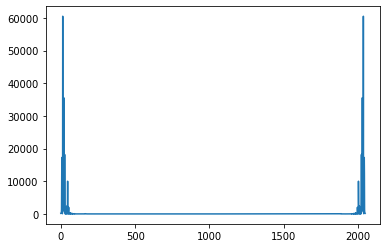

In [10]:
fft = abs(fft) ** 2
plt.plot(fft)

This is not a very informative plot yet. The axis scales are not helpful yet. And we notice a symmetry:
For real input, the DFT components corresponding to negative frequencies will be the complex conjugates of the components corresponding to positive frequencies. Since we take the magnitude, we lose the information about the sign of the imaginary part and the two sides will be the same, but mirrored.

We can verify this empirically:

In [11]:
np.allclose(fft[1:window_size//2], fft[:window_size//2:-1])  # notice the step size -1 in the second argument

True

Since the two halves are the same, we can throw away half of the output. You may ask: Why bother calculating it then?
For real inputs, we generally don't. Libraries provide methods which don't do this extra calculation (`np.fft.rfft`). But if our input is not real, the output will not be redundant and the full algorithm is necessary.

Next, we will set the x scale correctly. According to the Shannon-Nyquist Theorem, the cutoff frequency at a sample rate of 44.1KHz is 22.05KHz. Because our signal samples were evenly spaced in the time domain, they will also be evenly spaced in the frequency domain. There are two equivalent ways of looking at that:

1. The DFT outputs range from -22.05KHz to 22.05 KHz in 2048 steps
2. The DFT outputs range from 0 to 22.05 KHz in 1024 steps.

So the frequency resolution is $\frac{44.1KHz}{2048}$ or $\frac{22.05KHz}{1024}$.

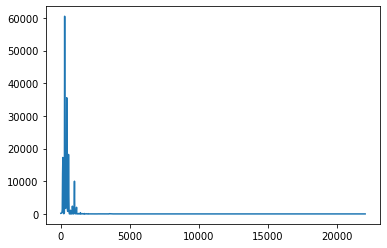

In [12]:
fft = fft[:window_size//2+1]
step_size = sample_rate / window_size
x_scale = np.arange(window_size//2+1) * step_size
plt.plot(x_scale, fft)

In principle, we are done. There is no unit for the y Axis, as we had no unit attached to out input data. However, when plotting a spectrum, it is typical to plot it in logarithmic scale on one or both axes.

We re-express the y values in dB, which is a logarithmic unit. Since dB is relative to some reference level, we arbitrarily choose the maximum in our data. We also set the x scaling to logarithmic. For audio applications, this is common practice, as humans also perceive audio frequencies on a logarithmic scale. For more information, you can look at the [Mel Scale](https://en.wikipedia.org/wiki/Mel_scale).

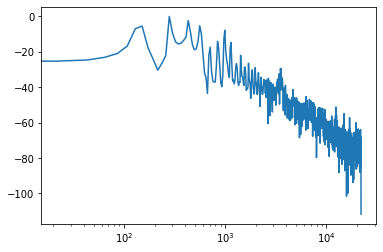

In [13]:
plt.plot(x_scale, 10*np.log10(fft / fft.max()))
plt.xscale("log")

In [14]:
def calculate_fft(samples):
    fft = np.abs(np.fft.fft(samples))[:len(samples)//2+1]
    fft = 20*np.log10(fft / fft.max())
    return fft

We collect all these steps into a function, as we will now repeat them under different conditions.

Slicing out part of our data is equivalent to multiplying with a square window. Multiplying in time domain is equivalent to convolution in frequency domain, so we always get some interference in our spectrum that is related to the spectrum of the window function in frequency domain.

A different windowing function that has a less intrusive profile in the frequency domain is the [Hamming Window](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.hamming.html). There is no *best* winwowing functions, they all have advantages and drawbacks.

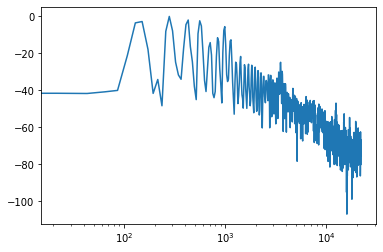

In [15]:
def hamming_window(size):
    return 25/46 - 21/46 * np.cos(2*np.pi*np.arange(size)/size)

plt.plot(x_scale, calculate_fft(part_samples * hamming_window(window_size)))
plt.xscale("log")

In this case, the Hamming window is an improvement, since we can see the peaks in our signal becoming more defined, because there is less background noise from the windowing function.

Here is another advanced technique: We throw away half of the data from the DFT and with it, half the resolution. What if there was a way to get it back somehow? For this, we append a number of zeros to our data equal to the number of actual datapoints. This doubles our data size and therefore our frequency resolution.

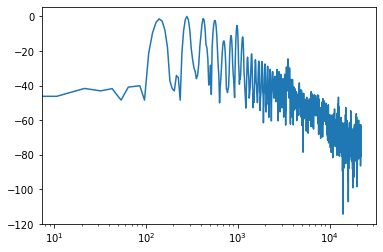

In [16]:
windowed_samples = part_samples * hamming_window(window_size)
padded_samples = np.concatenate([windowed_samples, np.zeros(window_size)])
padded_x_scale = np.linspace(0, sample_rate//2, window_size+1)
plt.plot(padded_x_scale, calculate_fft(padded_samples))
plt.xscale("log")

You can see the spectrogram becoming "smoother", as a result of the increased resolution. So is zero padding just a way to get free frequency resolution? Why stop at padding with 2048 zeros? Why not more?

To answer that, we need to understand what zero-padding does. It has no effect on the spectrum that is produced by the DFT. If we think of the spectrum as a continuous function that is being sampled by the DFT, we can sample it in more points by using zero padding. However, we do not actually get more frequency resolution on the spectrum itself.

Consider the previous plot (before zero padding): The first peak is actually two datapoints that are almost the same amplitude. It's possible that those are actually two peaks that are so close together that we cannot differentiate them with the amount of datapoints that we have. The only way to clearly resolve those two peaks is to use more real datapoints (assuming the input signal is stationary, which in our case it's not). Using zero padding simply gives us a higher resolution on the same function that the original DFT produces. If that function cannot differentiate two close peaks, then no amount of zero padding will help.

So is zero padding useless? No. Consider again the previous plot. If this first peak is actually only one peak, but it is located at a frequency somewhere between those two datapoints, its energy will be divided into those two datapoints according to how close they are to the real peak (this is why we often speak of frequency "bins", because each datapoint actually expresses frequency content from a range of frequencies). The DFT actually has enough data to find the frequency of the peak, it is just sampled at too low resolution. We can fix this with zero padding. In the zero padding graph, it is clearly visible where the peak is because we now have a datapoint exactly in the middle between the two previous ones.

To conclude, zero padding is good for:
1. Resolving the exact frequency of a peak, so long as that peak is detectable even without zero padding
2. Finding the exact amplitude of a peak, beacuse its energy is not split across several datapoints
3. Making sure that there is a datapoint at some frequency that you are interested in. For example, if you needed to know the amplitude at exactly 100 Hz, you could use zero padding to control the number of input samples to the DFT. If you know the sample rate, you can make sure that there is a data point at exactly 100 Hz
4. Padding your input to a power of 2 for the most efficient FFT algorithm

For a more in-depth look at zero padding, you can check out [this article](http://www.ni.com/tutorial/4880/en/), note also some of the top comments.

Lastly, we will draw a nice looking spectrogram. To do that, we calculate a spectrum as above for each window of data in the sound file. In our case, we shift the window right by 2048 steps each time, so we have non-overlapping windows. But it is also not uncommon to have overlapping windows in speech processing. We plot this (now 2D) data as a heatmap, where brighter colors correspond to a higher frequency content. X is the time axis, Y is the frequency axis.

C:\Users\Felix\.conda\envs\toolbag\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


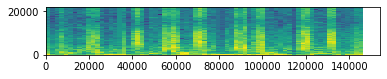

In [17]:
def spectrogram_column(start):
    windowed_samples = samples[start:start+window_size] * hamming_window(window_size)
    return calculate_fft(windowed_samples)

spectrogram = np.stack([spectrogram_column(start) for start in range(0, len(samples) - window_size + 1, window_size)], 1)
plt.imshow(spectrogram, origin="lower", extent=(0, len(samples), 0, sample_rate//2))

I hope this demonstration helped you understand the DFT and its output. If you want to play around in another interactive setting, I recommend trying [Audacity](https://www.audacityteam.org/), which allows you to control all settings of the DFT and see the effect on the spectrogram.